## Knapsack Problem

### Problem Statement

We have a set of cars of different sizes and values and a parking lot at the dealership with a limited car capacity. How do we choose which cars to pack into the parking lot to maximize the total sale value?

### Define Variables and Parameters

* $N$ is the number of cars
* $s_i$ is the size of car $i$
* $v_i$ is the value of car $i$
* $x_i$ is the decision variables: $x_i = 1$ if car $i$ is chosen and $x_i = 0$ if not
* $c_i$ is the carbon tax of the car $i$
* $C$ is the total carbon tax amount the dealership paid. 
* $S$ is the capacity of the parking lot

### Identify Constraints and Make Assumptions

* Total area of the parked items is less than the parking lot capacity

In [52]:
# Import Packages
import numpy as np
import cvxpy as cp
import pandas as pd
import matplotlib.pyplot as plt

In [53]:
df_new = pd.read_csv('data/complete_data.csv')
# total number of cars 
N = len(df_new)
# value of cars varies
profit = df_new['Profit']
# size of the cars varies
s = df_new["size"]
# total size of all cars
size = np.sum(s)
# parking lot capacity
S = 2*size/3

# Buying price for each car
b = df_new["Buying Price"]
# total amount of buying cost
budget = np.sum(b)
# total budget the dealership has
C = budget/4

fee_electric = 300
fee_imported = 1000

# Outputs
print("Total Number of cars ready to sell: ", N)
print("Total car value: $",np.sum(profit))
print("Total Size of cars: ",size, "m^2")
print("Total buying cost amount: $", budget)
print("------------------------------------------")
print("Parking Lot Capacity: ",S, "m^2")
print("Available Budget Amount: $", C)


print("---------------------------------------------------------------")
print("DealershipDecisionOptimizerSystem(DDOS) is working....")
# Solution

#adjusting array sizes to accommodate for penalty fee dummy variables
x = cp.Variable(N+2,integer=True)
s_wdummy=np.append(s, [0, 0])
b_wdummy=np.append(b, [0, 0])
profit_wdummy=np.append(profit, [-fee_electric, -fee_imported])

#creating ILP set up with space and budget constraints
obj = cp.Maximize(cp.sum(cp.multiply(profit_wdummy,x)))
constraints = [cp.sum(cp.multiply(s_wdummy,x)) <= S,
               cp.sum(cp.multiply(b_wdummy,x)) <= C,
               x <= 1, x >= 0]

#adding constraints for dummy e>=x_j, e<= sum(x_j) for all electric cars j and i>=x_k, i<=sum(x_k) for all imported cars k
e_sum=np.zeros(N+2)
i_sum=np.zeros(N+2)

df_new = df_new.reset_index(drop=True)
for k in range(len(df_new)):
    if ((df_new.loc[k, 'fuel_type'].lower() == 'Hybrid') or (df_new.loc[k, 'fuel_type'].lower() == 'Plug-In Hybrid')):
        constraints.append(x[k] >= x[N-2])
        e_sum[k]=1
    elif df_new.loc[k, 'imported'] == '1':
        constraints.append(x[k] >= x[N-1])
        i_sum[k]=1

constraints.append(cp.sum(cp.multiply(e_sum,x)) <= x[N-2])
constraints.append(cp.sum(cp.multiply(i_sum,x)) <= x[N-1])
	
prob = cp.Problem(obj,constraints)
prob.solve()
print("---------------------------------------------------------------")
print(np.sum(x.value), "cars sold")
print("Profit: $", profit_wdummy@x.value)
print("Actual Size of cars sold: ", s_wdummy@x.value, "m^2")
print("Actual budget spent: $", b_wdummy@x.value)

Total Number of cars ready to sell:  3223
Total car value: $ 26420798.85
Total Size of cars:  28942 m^2
Total buying cost amount: $ 106834878.15
------------------------------------------
Parking Lot Capacity:  19294.666666666668 m^2
Available Budget Amount: $ 26708719.5375
---------------------------------------------------------------
DealershipDecisionOptimizerSystem(DDOS) is working....
---------------------------------------------------------------
339.0 cars sold
Profit: $ 8301576.5
Actual Size of cars sold:  3032.0 m^2
Actual budget spent: $ 26708597.5


In [54]:
# approximation with greedy algorithm
fuel = df_new["fuel_type"].values
imported = df_new["imported"].values
profit = df_new['Profit'].values
budget = df_new['Buying Price'].values

global value_per_size 
value_per_size = profit/s

should_break=False

items = []
ev_record = []
import_record = []
global counter_import
counter_import = 0
global counter_EV
counter_EV = 0

EV_fee = 300
license_fee = 1000

# functions for the greedy algorithm:

# check the current profit for car i:
# takes in the index for car i, check if it is EV or Imported, and deduct profit accordingly.
def check_price(i):
    fuel_type = fuel[i]
    status = imported[i]
    i_profit = profit[i]
    # fuel deduction:
    if ((fuel_type == 'Hybrid') or (fuel_type == "Plug-In Hybrid")):
        if (counter_EV == 1):
            return i_profit
        else: 
            i_profit -= EV_fee
            return i_profit
    # import deduction
    elif (status == 1):
        if (counter_import == 1):
            return i_profit
        else:
            i_profit -= license_fee
            return i_profit
    else:
        return i_profit
    
# easy function for updating the status
def Update_EV():
    global counter_EV 
    counter_EV = 1
def Update_Import():
    global counter_import
    counter_import = 1

def Downdate_EV():
    global counter_EV 
    counter_EV = 0
def Downdate_Import():
    global counter_import
    counter_import = 0

# check if the car i is EV or imported
def check_EV(i):
    return ((fuel[i] == 'Hybrid') or (fuel[i] == "Plug-In Hybrid"))

def check_import(i):
    return (imported[i] == 1)

def check_constraints():
    total_size = sum([s[k] for k in items])
    total_budget = sum([budget[k] for k in items])
    if ((total_size > S) or (total_budget > C)):
        items.pop()
        return True
    else:
        return False

In [68]:
while True:
    # Find the most valuable item
    sorted_indices = np.argsort(value_per_size)[::-1]  # Indices sorted in descending order
    i = sorted_indices[0]  # Index of the largest item
    j = sorted_indices[1]    
    if value_per_size[i] == 0:
        break
    else:
        ev_record.append(check_EV(i))
        import_record.append(check_import(i))
        if (check_price(i) >= check_price(j)):
            items.append(i)
            # update the counter if necessary
            if check_EV(i):
                Update_EV()
            elif check_import(i):
                Update_Import()
            value_per_size[i] = 0  
            if(check_constraints()):
                should_break=True
        else:
            items.append(j)
            # update the counter if necessary
            if check_EV(j):
                Update_EV()
            elif check_import(j):
                Update_Import()
            value_per_size[j] = 0  
            if(check_constraints()):
                should_break=True
    if (should_break):
        break

In [69]:
print("Total Number of cars ready to sell: ", N)
print("Total car value: $",np.sum(profit))
print("Total Size of cars: ",size, "m^2")
print("Total buying cost amount: $", sum(budget))
print("------------------------------------------")
print("Parking Lot Capacity: ",S, "m^2")
print("Available Budget Amount: $", C)


print("---------------------------------------------------------------")
print("Dealership Decision Optimizer Greedy System(D-DOGS) is working....")
print("---------------------------------------------------------------")
print(len(items), "cars sold")
print("Profit: $", sum(profit[items]))
print("Actual Size of cars sold: ", sum(s[items]), "m^2")
print("Actual budget spent: $", sum(budget[items]))

Total Number of cars ready to sell:  3223
Total car value: $ 26420798.85
Total Size of cars:  28942 m^2
Total buying cost amount: $ 106834878.15000054
------------------------------------------
Parking Lot Capacity:  19294.666666666668 m^2
Available Budget Amount: $ 26708719.5375
---------------------------------------------------------------
Dealership Decision Optimizer Greedy System(D-DOGS) is working....
---------------------------------------------------------------
126 cars sold
Profit: $ 7041543.550000001
Actual Size of cars sold:  1093 m^2
Actual budget spent: $ 26681627.450000003


## Some data analysis on profit of different types of cars

In [70]:
unique_brands = df_new["brand"].unique()
print(unique_brands)

['Ford' 'Hyundai' 'INFINITI' 'Audi' 'BMW' 'Lexus' 'Aston' 'Toyota'
 'Lincoln' 'Land' 'Mercedes-Benz' 'Dodge' 'Nissan' 'Jaguar' 'Chevrolet'
 'Kia' 'Jeep' 'Bentley' 'MINI' 'Porsche' 'Hummer' 'Chrysler' 'Acura'
 'Volvo' 'Cadillac' 'Maserati' 'Genesis' 'Volkswagen' 'GMC' 'RAM' 'Subaru'
 'Alfa' 'Ferrari' 'Scion' 'Mitsubishi' 'Mazda' 'Saturn' 'Honda' 'Bugatti'
 'Lamborghini' 'Rolls-Royce' 'McLaren' 'Buick' 'Lotus' 'Pontiac' 'FIAT'
 'Saab' 'Mercury' 'Plymouth' 'smart' 'Maybach' 'Suzuki']


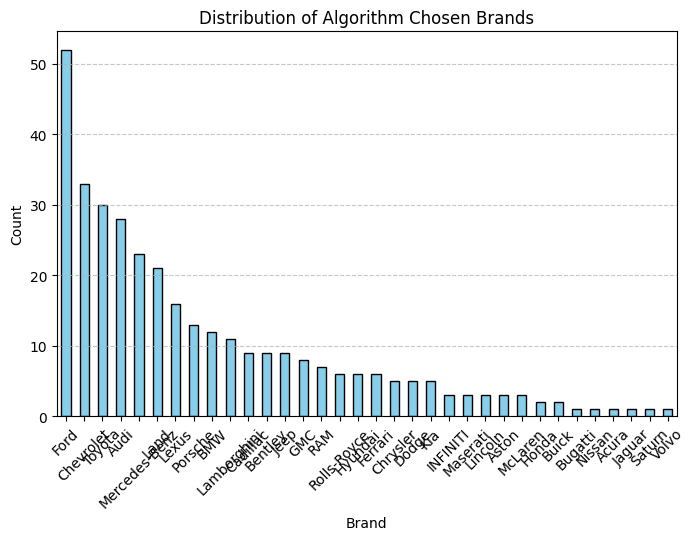

In [71]:
algorithm_selected_index = [i for i, val in enumerate (x.value) if val == 1]
selected_brand = df_new.loc[algorithm_selected_index, "brand"]
brand_counts = selected_brand.value_counts()
plt.figure(figsize=(8,5))
brand_counts.plot(kind="bar", color = "skyblue", edgecolor="black")
plt.xlabel("Brand")
plt.ylabel("Count")
plt.title("Distribution of Algorithm Chosen Brands")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("data/algo_brand.png", dpi=300, bbox_inches="tight")
plt.show()

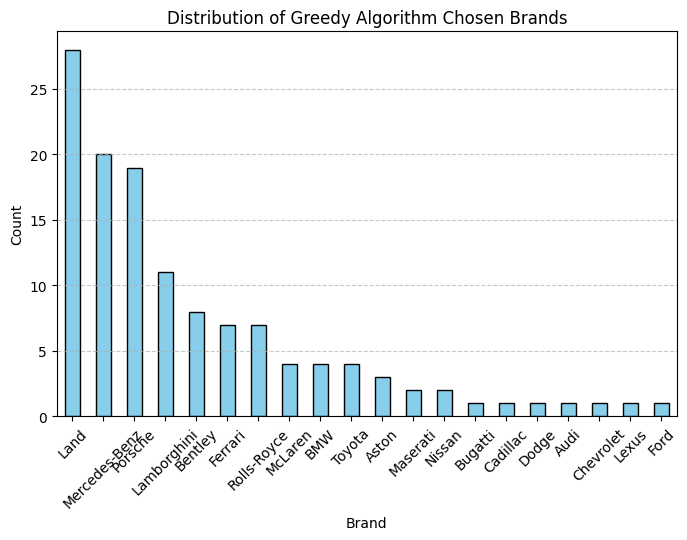

In [72]:
greedy_selected_brand = df_new.loc[items, "brand"]
brand_counts = greedy_selected_brand.value_counts()
plt.figure(figsize=(8,5))
brand_counts.plot(kind="bar", color = "skyblue", edgecolor="black")
plt.xlabel("Brand")
plt.ylabel("Count")
plt.title("Distribution of Greedy Algorithm Chosen Brands")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("data/greedy_brand.png", dpi=300, bbox_inches="tight")
plt.show()

In [73]:
hybrid__profit = df_new[df_new['fuel_type'].isin(['Hybrid'])]['Profit'].mean()
plug_in_profit = df_new[df_new['fuel_type'].isin(['Plug-In Hybrid'])]['Profit'].mean()

# Calculate the mean profit for Gasoline cars
gasoline_profit = df_new[df_new['fuel_type'] == 'Gasoline']['Profit'].mean()

# Print the results
print("Mean profit for Hybrid or Plug-In Hybrid cars:", hybrid__profit)
print("Mean profit for Plug-In Hybrid cars:", plug_in_profit)
print("Mean profit for Gasoline cars:", gasoline_profit)

Mean profit for Hybrid or Plug-In Hybrid cars: 17037.463448275863
Mean profit for Plug-In Hybrid cars: 2188.136363636364
Mean profit for Gasoline cars: 8122.0924333925395


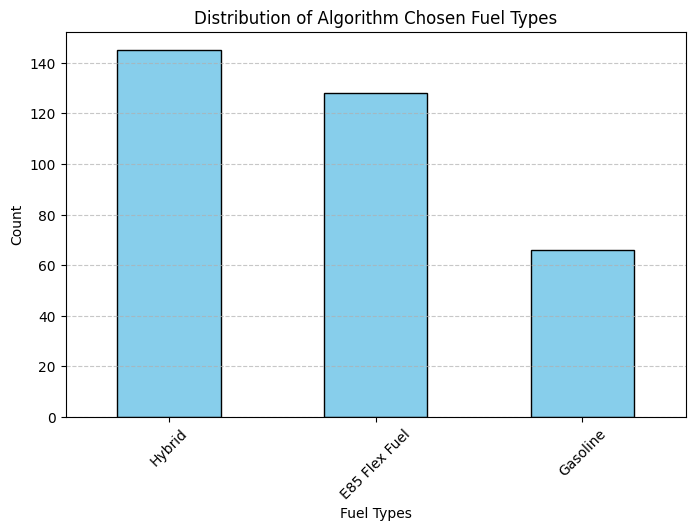

In [74]:
algorithm_selected_fuel = df_new.loc[algorithm_selected_index, "fuel_type"]
brand_counts = algorithm_selected_fuel.value_counts()
plt.figure(figsize=(8,5))
brand_counts.plot(kind="bar", color = "skyblue", edgecolor="black")
plt.xlabel("Fuel Types")
plt.ylabel("Count")
plt.title("Distribution of Algorithm Chosen Fuel Types")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("data/algo_fuel.png", dpi=300, bbox_inches="tight")
plt.show()

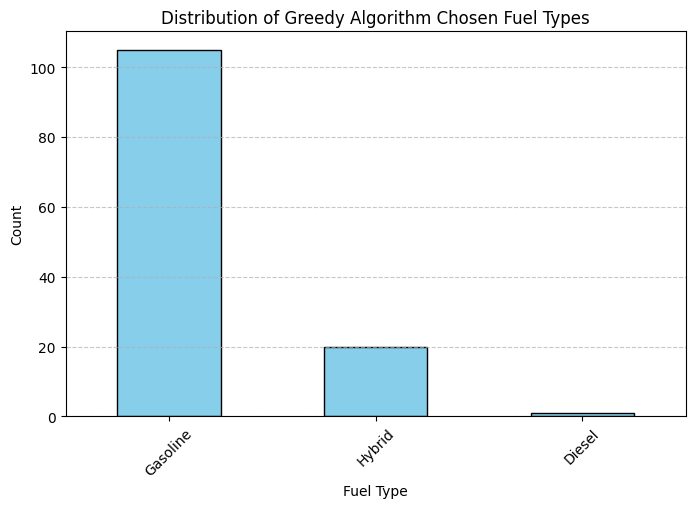

In [75]:
greedy_selected_fuel = df_new.loc[items, "fuel_type"]
brand_counts = greedy_selected_fuel.value_counts()
plt.figure(figsize=(8,5))
brand_counts.plot(kind="bar", color = "skyblue", edgecolor="black")
plt.xlabel("Fuel Type")
plt.ylabel("Count")
plt.title("Distribution of Greedy Algorithm Chosen Fuel Types")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("data/greedy_fuel.png", dpi=300, bbox_inches="tight")
plt.show()

In [76]:
import_profit = df_new[df_new['imported'] == 1]['Profit'].mean()

# Calculate the mean profit for Gasoline cars
non_import_profit = df_new[df_new['imported'] == 0]['Profit'].mean()

# Print the results
print("Mean profit for import cars:", import_profit)
print("Mean profit for domestic cars:", non_import_profit)

Mean profit for import cars: 7763.693885601577
Mean profit for domestic cars: 8585.323413631022


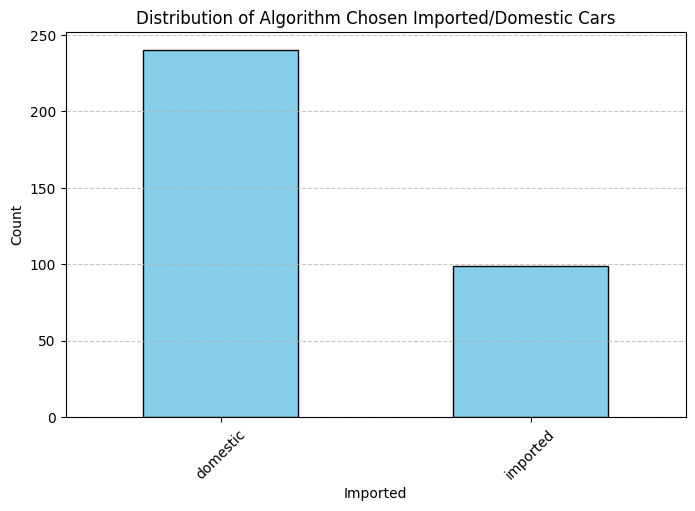

In [77]:
algorithm_selected_fuel = df_new.loc[algorithm_selected_index, "imported"].map({0: 'domestic', 1: 'imported'})
brand_counts = algorithm_selected_fuel.value_counts()

# Plot the bar chart
plt.figure(figsize=(8, 5))
brand_counts.plot(kind="bar", color="skyblue", edgecolor="black")
plt.xlabel("Imported")
plt.ylabel("Count")
plt.title("Distribution of Algorithm Chosen Imported/Domestic Cars")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("data/algo_import.png", dpi=300, bbox_inches="tight")
plt.show()


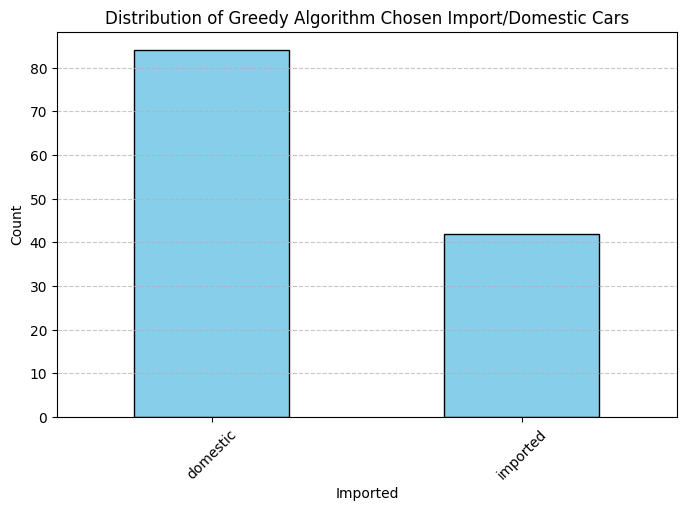

In [78]:
greedy_selected_import = df_new.loc[items, "imported"].map({0: 'domestic', 1: 'imported'})
brand_counts = greedy_selected_import.value_counts()
plt.figure(figsize=(8,5))
brand_counts.plot(kind="bar", color = "skyblue", edgecolor="black")
plt.xlabel("Imported")
plt.ylabel("Count")
plt.title("Distribution of Greedy Algorithm Chosen Import/Domestic Cars")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("data/greedy_import.png", dpi=300, bbox_inches="tight")
plt.show()